**ANALYSIS OF WINE REGIONS BASED ON PHYSICAL AND CHEMICAL CHARACTERISTICS**

Contributors:
>12981056 - Heather Au 
>
>61499182 - Connor Moynihan

In [3]:
library(tidyverse)
library (tidymodels)
library(repr)
library(ggplot2)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


**Introduction**

Wine typically, is classified regionally, ie: Bordeaux, France; Tuscany, Italy; Napa Valley, United States. Wines from these regions are categorized by their unique taste, smell, and alcohol contents; however, individual cultivars, grapes, and vineyards can, and do produce massively different wines, in both price point and variety. Given a dataset of ~180 wines spanning three different cultivars from the same region in Italy, it would be massively successful and useful to identify each individual cultivar. The data set contains 13 attributes, all numeric, which describe the wine both chemically and visually, ranging from the color intensity, to the Mg content within the wines. 

**Methods and Results**

First we need to load the data which can be found on github and tidy the data by turning the column: **Wine** from double into a factor variable. We can also check for any missing data, although UC Irvine, the distributor of data has already verified there is no missing information.

In [5]:
wine <- read_csv(url("https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv"))

print ("Table 1: Tidied Wine Data")
wine_tidy <- mutate (wine, Wine = as_factor (Wine))
wine_tidy

print("Rows of missing data")
wine_tidy_na <- sum (is.na(wine_tidy))
wine_tidy_na

Rows: 178 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): Wine, Alcohol, Malic.acid, Ash, Acl, Mg, Phenols, Flavanoids, Nonf...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Tidied Wine Data"


Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
3,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


[1] "Rows of missing data"


[1] 0

From the initial inspection of table 1 there is no missing data, and there are 3 different types of wine that are seperated into different attributes. These attributes are all quantitative which means all of the attributes could possibily be used to classify the wine.

With table 1 we have a lot of different attributes but some of the attributes may be irrevelevant when classifying and this will impact the classifier's accuracy. To find a good predictor, we initially tried to filter the predictors with scientific reasoning. However, we found that all attributes are reasonable candidates, thus we can try to use visualizations to help understand which variables are relevant. To create the visualization the data needs to be split and scaled to ensure only the training data is manipulated and no single atttribute will dominate the distance calculation.

In [6]:
set.seed (999)

#Split the data into training and testing data
wine_split <- initial_split (wine_tidy, prop = 0.75, strata = Wine)
wine_train <- training (wine_split)
wine_test <- testing (wine_split)

print ("Table 2: Scaled data set for graphing")
wine_train_recipe <- recipe (Wine ~ ., data = wine_train) |>
    step_scale (all_predictors ()) |>
    step_center (all_predictors ())

wine_train_scaled <- wine_train_recipe |>
    prep () |>
    bake (wine_train)

wine_train_alcohol <- wine_train_scaled |>
    pivot_longer (
        cols = Malic.acid:Proline,
        names_to = "attributes",
        values_to = "values"
    )
wine_train_alcohol

[1] "Table 2: Scaled data set for graphing"


Alcohol,Wine,attributes,values
<dbl>,<fct>,<chr>,<dbl>
1.457754,1,Malic.acid,-0.5534172
1.457754,1,Ash,0.2149106
1.457754,1,Acl,-1.1165905
⋮,⋮,⋮,⋮
1.338347,3,Hue,-1.5104474
1.338347,3,OD,-1.4202811
1.338347,3,Proline,-0.5805392


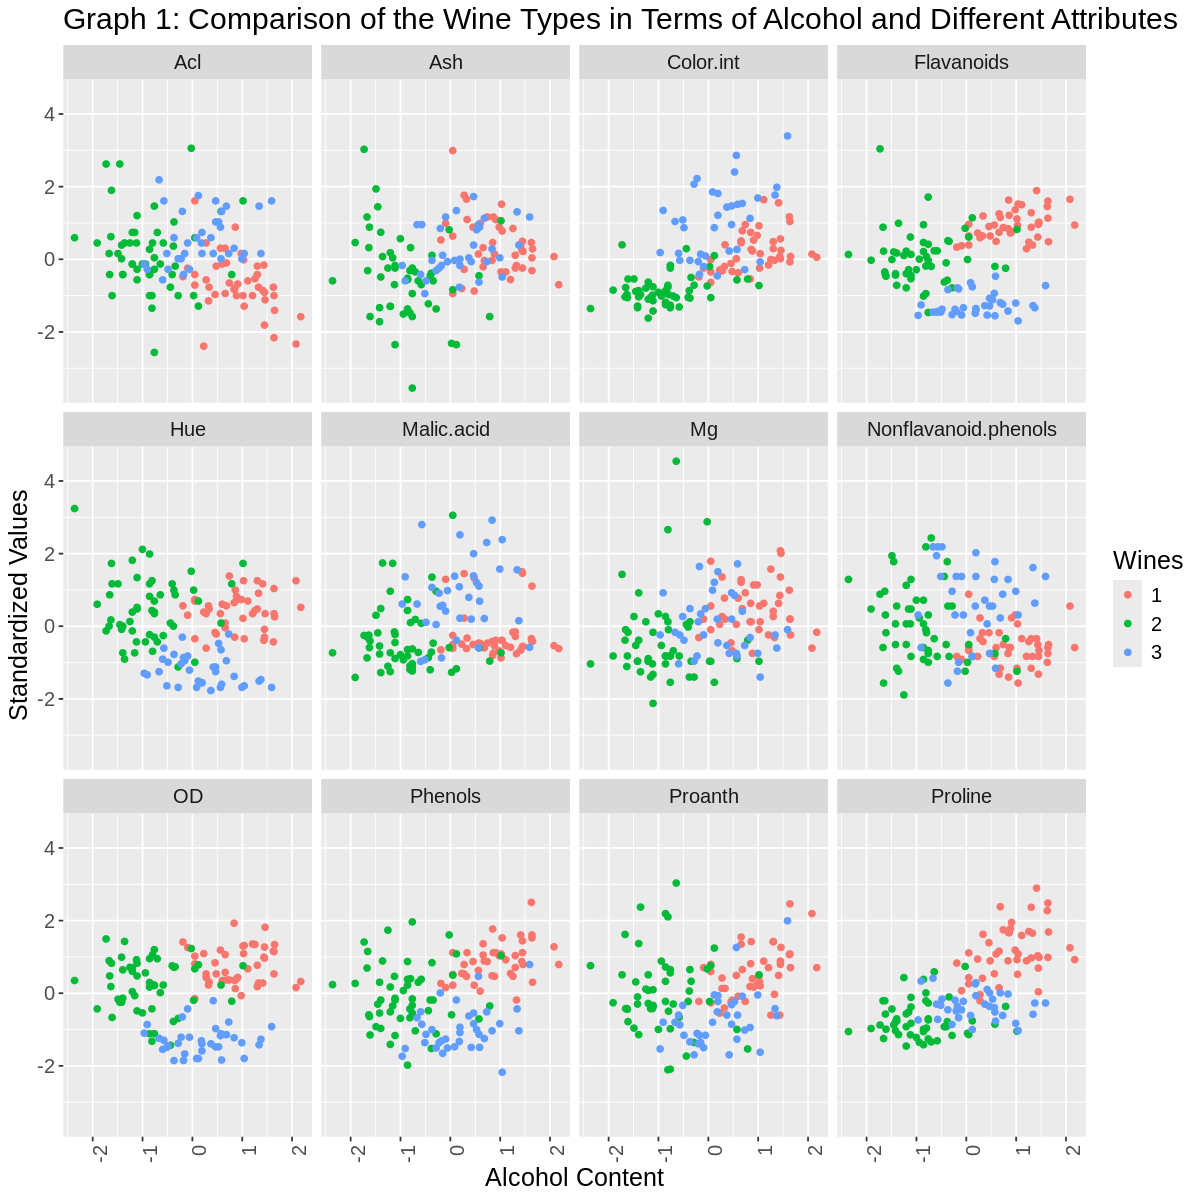

In [7]:
options (repr.plot.width = 10, repr.plot.height = 10)
wine_plot_facet <- wine_train_alcohol |>
    ggplot (aes (x = Alcohol, y = values, color = Wine)) +
    geom_point () +
    labs (x = "Alcohol Content",
          y = " Standardized Values",
          color = "Wines",
          title = "Graph 1: Comparison of the Wine Types in Terms of Alcohol and Different Attributes ") +
    facet_wrap (~attributes) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    theme(text = element_text(size=15))
wine_plot_facet

Looking at the graph 1, one can see that trying to use a visualization to determine if the attribute is a good predictor is not useful because the selection would be very subjective and the visualization is only comparing the attributes to alcohol content. If alcohol content is not a good predictor than the visualization is not useful and this way of selecting predictors in very time-consuming with 13 attributes and error-prone.

Intially, we were thinking about using the variable selction method called: best subject selection. However, the drawbacks of this method of variable selection is that for our data set of 13 different variables the models we would have to train 8191 models. Therefore, in practice we need to use another method that is not so computationally heavy (Beale, Kendall, and Mann 1967; Hocking and Leslie 1967). Knowing this we decided to use a method called forward selection. This method requires us to build a model by adding one predictor variable at a time. This means that at the end we will have 91 models to determine best fit, which is significantly better than 8191 models in the best subject selection method (Eforymson 1966; Draper and Smith 1966).

To start to use forward selection we need to select the columns with the attributes and the Wine variable. The `paste` function is used to create the model's formula for each subset of predictors. The `collapse` function here places a `+` symbol between each variable. We used two loops, one over increasing perdictors size (`for (i in 1:length (names))`), and another to check which predictor to add in each round (`j in 1:length(names)`). For each set of predictors, we construct a model forumula that goes into a `recipe` then builds a `workflow` that tunes a K-NN classifier using 5-fold cross-validation and then selects the largest estimated accuracy. 

In [15]:
set.seed (999)
# selecting the attributes and Wine variable
wine_subset <- wine_tidy |>
  select(Wine,
         Alcohol, 
         Malic.acid, 
         Ash, 
         Acl, 
         Mg, 
         Phenols, 
         Flavanoids, 
         Nonflavanoid.phenols, 
         Proanth, 
         Color.int, 
         Hue, 
         OD, 
         Proline)

# extract column names for the full set of predictors
names <- colnames(wine_subset |> select(-Wine))

# the model formula for all predictors
wine_formula_forward <- paste("Wine", "~", paste(names, collapse="+"))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(),
                     model_string = character(),
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
wine_vfold <- vfold_cv(wine_subset, v = 5, strata = Wine)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Wine", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        wine_recipe <- recipe(as.formula(model_string),
                                data = wine_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the K-NN classifier with these predictors,
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(wine_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = wine_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
      add_row(size = i,
              model_string = models[[jstar]],
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
print ("Table 3: Best Predictor Variables and Its Accuracy")
accuracies_max <- accuracies |>
    filter(accuracy == max(accuracy))
accuracies_max
     

[1] "Table 3: Best Predictor Variables and Its Accuracy"


size,model_string,accuracy
<int>,<chr>,<dbl>
5,Wine ~ Flavanoids+Alcohol+Hue+Proline+Mg,0.989039


Based on table 3, we can see that there are 5 useful variables which are Flavanoids, Alcohol, Hue, Proline, Mg. Based on the highest accuracy out of all the models. Therefore with this information, we can further tidy the data with only the 5 variables.

In [8]:
print("Table 4: Tidied Data")
improved_wine <- wine_tidy |>
    select(Wine, Flavanoids, Alcohol, Hue, Proline, Mg)
improved_wine

[1] "Table 4: Tidied Data"


Wine,Flavanoids,Alcohol,Hue,Proline,Mg
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.06,14.23,1.04,1065,127
1,2.76,13.20,1.05,1050,100
1,3.24,13.16,1.03,1185,101
⋮,⋮,⋮,⋮,⋮,⋮
3,0.69,13.27,0.59,835,120
3,0.68,13.17,0.60,840,120
3,0.76,14.13,0.61,560,96


With tidied data in table 4, we can now determine what K value we should use in the classification. To do this we split the data and will only scale and center the `wine_train` data. To perform a 10-fold cross-validation to create the `k_vals` data frame containing values from 1 to 100. Then we use the argument `tune_grid` and `collect_metrics` to get the accuracy estimate for each neighbor value. We filter for accuracy. We can visualize the the best K value by plotting the accuracy versus neighbors and we also pulled the best K value.

[1] "Best K:"


[1] 11

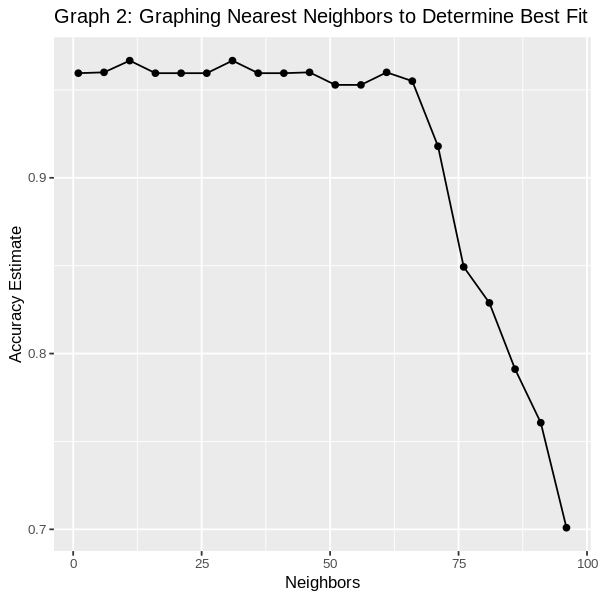

In [9]:
set.seed (999)
improved_wine_split <- initial_split (improved_wine, prop = 0.75, strata = Wine)
wine_train <- training (improved_wine_split)
wine_test <- testing (improved_wine_split)

improved_wine_train_recipe <- recipe (Wine ~ ., data = wine_train) |>
    step_scale (all_predictors ()) |>
    step_center (all_predictors ())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

wine_vfold_10 <- vfold_cv(wine_train, v = 10, strata = Wine)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(improved_wine_train_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = wine_vfold_10, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")
  
options (repr.plot.width = 5, repr.plot.height = 5)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  ggtitle("Graph 2: Graphing Nearest Neighbors to Determine Best Fit") +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 10))

accuracy_vs_k

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
print("Best K:")
best_k

According to Graph 2, the nearest neighbors we should be using for our classifier is 11 which is the peak that is seen in the graph. Setting the number of neighbors to K = 11 will provide the highest cross-validation accuracy estimate.

With K = 11, we can creat a new knn_spec and with it and the `improved_wine_train_recipe` we can fit the data to build the classifier using the training data.

In [10]:
knn_spec_11 <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(improved_wine_train_recipe) |>
  add_model(knn_spec_11) |>
  fit(data = improved_wine)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02808989
Best kernel: rectangular
Best k: 11

With the K-nearest neighbors classifier, we can use it to predict the Wine cultivars for our test set.

In [11]:
print ("Table 5: Classifier's prediction")
wine_test_predictions <- predict(knn_fit, wine_test) |>
  bind_cols(wine_test)
wine_test_predictions

[1] "Table 5: Classifier's prediction"


.pred_class,Wine,Flavanoids,Alcohol,Hue,Proline,Mg
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,3.24,13.16,1.03,1185,101
1,1,3.39,14.20,1.05,1450,112
1,1,3.14,14.30,1.07,1280,120
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,3,0.68,13.78,0.70,615,90
3,3,0.47,13.73,0.78,520,88
3,3,0.69,13.27,0.59,835,120


With the classifier built and the predictions made we can examine multiple things to determine the performance of the classifier. We can look at accuracy, precision, recall and the confusion matrix. 

In [14]:
print("Table 6: Accuracy of Classifier")
accuracy <- wine_test_predictions |>
    metrics(truth = Wine, estimate = .pred_class) |>
    filter(.metric == "accuracy")
accuracy

print ("Table 7: Precision of Classifier")
precision <- wine_test_predictions |>
    precision(truth = Wine, estimate = .pred_class, event_level="first")
precision

print ("Table 8: Recall of Classifier")
recall <- wine_test_predictions |>
    recall(truth = Wine, estimate = .pred_class, event_level="first")
recall

print ("Table 9: Confusion Matrix")
confusion <- wine_test_predictions |>
             conf_mat(truth = Wine, estimate = .pred_class)
confusion

[1] "Table 6: Accuracy of Classifier"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9777778


[1] "Table 7: Precision of Classifier"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.974359


[1] "Table 8: Recall of Classifier"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,macro,0.9814815


[1] "Table 9: Confusion Matrix"


          Truth
Prediction  1  2  3
         1 15  0  0
         2  0 17  0
         3  0  1 12

**Discussion**

Table 9 indicates that 15 observations were accurately classified as Wine 1, 17 observations were correctly predicted as Wine 2, and 12 observations were accurately labeled as Wine 3. Nevertheless, the classifier misclassified an observation as Wine 3 instead of Wine 2. To evaluate the performance, we calculated the classifier's accuracy, precision, and recall. The accuracy of our classifier in Table 6 is 97.78%, which is acceptable as the classifier only made one error. In Table 7, precision is 97.43%; therefore, when the classifier reports that a new observation is a certain Wine 1, we can be confident it is true. The recall is 98.15% in Table 8; the high recall means that if there is a Wine 1, we can be certain that the classifier will find it. Based on the evaluation, the classifier is really good at predicting the wine type.

We are not expecting the classifier to be perfect, but we were anticipating that it would perform very well because in Graph 1, we can see that when alcohol is compared to the different attributes, the wine types are visually clustered together. Therefore, when the classifier is predicting the wine types, we expected it to have a high degree of accuracy, precision, and recall, which is evident in the results we see in Table 9 (confusion matrix). Knowing that the classifier is reliable, we could use it for wine fraud detection. This is significant because the classifier can be employed to identify fake wines posing as expensive luxury wines, where the fake wine may have added sweeteners and even harmful chemicals. Future inquiries may ask, "How accurate is this model in predicting aged wine?" or "What age is the wine in this model?"

**References**

Aeberhard,Stefan and Forina,M.. (1991). Wine. UCI Machine Learning Repository. https://doi.org/10.24432/C5PC7J.

Beale, Evelyn Martin Lansdowne, Maurice George Kendall, and David Mann. 1967. “The Discarding of Variables in Multivariate Analysis.” Biometrika 54 (3-4): 357–66.

Draper, Norman, and Harry Smith. 1966. Applied Regression Analysis. Wiley.

Eforymson, M. 1966. “Stepwise Regression—a Backward and Forward Look.” In Eastern Regional Meetings of the Institute of Mathematical Statistics.

Hocking, Ronald, and R. N. Leslie. 1967. “Selection of the Best Subset in Regression Analysis.” Technometrics 9 (4): 531–40.